<a href="https://colab.research.google.com/github/prasvijaya/datascienceportfolio/blob/master/Sentimental_analysis_using_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java-version 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/bin/bash: java-version: command not found


In [2]:
!pip install h2o

In [3]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h2o
import nltk
import spacy
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from h2o.automl import H2OAutoML

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 43 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_ouka7d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.020 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [5]:
dataset, info = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', with_info=True, batch_size=-1)
train_dataset= dataset['train']

In [6]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [7]:
dataset= tfds.as_numpy(train_dataset)
dataset

{'data': {'customer_id': array([b'13986323', b'50574716', b'50593972', ..., b'40719682',
         b'35596948', b'29430209'], dtype=object),
  'helpful_votes': array([0, 3, 0, ..., 0, 0, 0], dtype=int32),
  'marketplace': array([b'US', b'US', b'US', ..., b'US', b'US', b'US'], dtype=object),
  'product_category': array([b'Personal_Care_Appliances', b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', ..., b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', b'Personal_Care_Appliances'],
        dtype=object),
  'product_id': array([b'B00847JQZ6', b'B00N5HD340', b'B0077L1X24', ..., b'B000UZ8X2W',
         b'B000NURPPK', b'B001EY5GNW'], dtype=object),
  'product_parent': array([b'997683625', b'955577225', b'120764066', ..., b'96066145',
         b'58591097', b'986877728'], dtype=object),
  'product_title': array([b'SE - Reading Glass - Spring Loaded Hinges, 4.0x - RTS62400',
         b'Straight Razor',
         b'Philips Sonicare Flexcare & Healthy White Plastic

We have review_body, review_headline consists of unstructured Text data. We will use these two columns for our building. Based on our baseline performance we will add new features based on weightage. star_rating will consists of rating ranges from 1-5 where 5 is highest rating. We need to perform sentiment analysis based on star_rating. We can either consider this target class as it to build multiclassification or transform to have 2 class labels for Binary Classification. For now, we will build it binary clasification

In [8]:
review_headline= dataset['data']['review_headline']
review_body= dataset['data']['review_body']
rating= dataset['data']['star_rating']

based on above 3 variables, we will create H20 dataframe like we create pandas dataframe.

In [9]:
h2o_df=h2o.H2OFrame(np.hstack((review_headline[:,None],review_body[:,None],rating[:,None])),column_names=['headline','reviews','rating'],column_types=['string','string','numeric'])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [10]:
h2o_df.head()

headline,reviews,rating
b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4
b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5
b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4
b'Five Stars',b'Top quality.',5
b'*Product sent not as shown',"b'Today I received 1 Fl. Oz, Natures Balance AlkaMAX alkaline booster liquid unflavored (formally TriMedica) a glass brown bottle with eye dropper.<br />Supplement Facts; Serving Size: 10 Drops (Approx. 0.5 mL). Servings per Container: Approx. 60<br />Amount Per Serving % Daily Value<br />Magnesium (as Magnesium Chloride) 40 mg 10%<br />Chloride (as Magnesium Chloride) 64 mg 2%<br />Other Ingredients: Deionized water and trace mineral complex.<br />Directions: Add 10 drops to 8 oz. of water or other beverage daily as needed or as directed by your health care practitioner. Store in a cool, dry place.<br /><br />I have not used product as of yet with changed ingredients of original/as shown in AlkaMax alkaline support white squeeze bottle.<br />but had to rate to post...heck this new may be better for all I know.'",3
b'Seems to work well!',"b'I recently picked this unit up at Bed and Bath where it was $99.00. With a 20% coupon the price was $80 (so comparison shop!) It\'s easy to use and seems to work well. I agree with other reviewers about the noise level (loud like a tea kettle boiling), but I use this unit in the living room area so sleeping is not an issue. Having the 2 separate water reservoirs to fill is much easier, weight-wise, as I previously had another humidifier which had one large water reservoir and it was very heavy when full. The unit comes apart quite easily for cleaning and since frequent cleaning is recommended (I usually do it 1x per week, not daily) this is a definite plus. Additionally, one only needs to use vinegar to clean the inside reservoir, which is a lot cheaper than having to buy some kind of \\\\""special\\\\"" cleaning solution. My one complaint is that it doesn\'t, but should, have an automatic shut off when both tanks are empty.I have to remember to turn the unit off when I leave the house. My previous humidifiers all had this auto turn off; seems like every humidifier should.'",4
b'deep heat?????',"b'Not sure what previous reviewer was talking about. The product uses ULTRASOUND waves for pain relief NOT heat. After repeated use, the pain in my knee and shoulder was feeling great. I think you should re-read the description and reconsider your opinion. Great product sold by a great company.'",5
b'Thermometer for a toddler',"b""The shippers were great....willing to consider speedier shipping options, but in the end the standard shipping arrived quickly enough. The thermometer is fun and

In [11]:
h2o_df.shape

(85981, 3)

In [12]:
h2o_df.describe()

Rows:85981
Cols:3




,headline,reviews,rating
type,string,string,int
mins,NaN,NaN,1.0
mean,NaN,NaN,3.9774019841592847
maxs,NaN,NaN,5.0
sigma,NaN,NaN,1.4331302919714732
zeros,0,0,0
missing,0,0,0
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4.0
1,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5.0
2,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4.0


In [13]:
h2o_df['rating'].table()

rating,Count
1,11036
2,5341
3,7050
4,13657
5,48897


As you see, rating classes are imbalanced and labels ranging from 1-5. we can create new target column to make this rating into Binary values

In [14]:
h2o_df['target'] = (h2o_df['rating'] >= 4).ifelse("1", "0")

In [15]:
h2o_df['target'].table()

target,Count
0,23427
1,62554


You could see target labels are changed to Binary. Class Labels are imbalanced as minor class is very low compared to major class

In [16]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def tokenize(line):
  tokenized = line.tokenize("\\W+")
  tokenized = tokenized.tolower()
  tokenized = tokenized[(tokenized.nchar() >= 2) | (tokenized.isna()),:]
  tokenized_filter = tokenized[(tokenized.isna()) | (~ tokenized.isin(stop_words)),:]
  return tokenized_filter

In [18]:
words_reviews = tokenize(h2o_df["reviews"])

In [19]:
words_headline = tokenize(h2o_df["headline"])

In [20]:
words_reviews.head()

C1
glasses
excellent
value
fit
good
comfortable
legal
blindness
lot
options


In [21]:
words_headline.head()

C1
glasses
excellent
value
fit
good
""
fantastic
way
cheaply
try


Above two cells shows the first few tokens of words_reviews and words_headline.

In [22]:
print(words_reviews.shape, words_headline.shape)

(2797601, 1) (319384, 1)


In [23]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators import H2OGradientBoostingEstimator, H2OXGBoostEstimator

To create word embedding H2OWord2vec package is imported.

In [24]:
vec_model = H2OWord2vecEstimator(vec_size= 100, model_id='w2v_amazon.model')
vec_model.train(training_frame=words_reviews)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [26]:
vec_model=h2o.load_model('w2v_amazon.model')

In [27]:
vec_model.find_synonyms('razor', count=5)

OrderedDict([('razors', 0.8614895343780518),
             ('blade', 0.789276659488678),
             ('shaving', 0.7648120522499084),
             ('parker', 0.7562313675880432),
             ('futur', 0.7501994371414185)])

In [28]:
vec_model.find_synonyms('soap', count=10)

OrderedDict([('castile', 0.7319657802581787),
             ('lather', 0.6907471418380737),
             ('maggie', 0.6898291110992432),
             ('conk', 0.6733875274658203),
             ('soaps', 0.6679428219795227),
             ('detergent', 0.6678946018218994),
             ('foaming', 0.664849579334259),
             ('proraso', 0.650361955165863),
             ('scum', 0.6401647329330444),
             ('col', 0.6398206949234009)])

In [29]:
vec_model.find_synonyms('glasses', count=5)

OrderedDict([('sunglasses', 0.8896998763084412),
             ('readers', 0.858310878276825),
             ('lenses', 0.8136168718338013),
             ('bifocal', 0.8060529232025146),
             ('bifocals', 0.7831657528877258)])

Vocabulary is created from training text data. So, what word2vec do it actually creates vector representation of vocabulary and place the similar words close to eachother. As you see in above example, sunglasses, readers, bifocal, lenses are closer words to 'glasses'. Since the similar words are closed to eachother we dont lose context.

In [30]:
review_vecs= vec_model.transform(words_reviews, aggregate_method='AVERAGE')
review_vecs.shape

(85981, 100)

In [31]:
review_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.1003,-0.0740767,-0.0589185,-0.00645441,0.0583679,-0.152467,0.0322643,-0.0940401,0.126928,-0.0713192,0.12213,-0.116903,-0.0754373,-0.0902056,0.0386389,-0.0937174,0.101485,-0.0405968,-0.000471398,0.041765,0.0991444,-0.0915442,0.0450429,-0.130821,0.15619,-0.0990996,0.0455004,-0.264614,-0.0693596,0.0382526,-0.0484659,0.0173552,-0.0341113,0.145514,-0.0608501,-0.00584735,0.0310851,0.0168693,0.0510612,-0.0577526,-0.0071127,0.167798,-0.0460585,-0.00996371,-0.0925639,-0.0137503,0.0874063,0.179076,-0.0245744,-0.064321,0.113734,0.104508,-0.115508,-0.0235825,-0.0163045,-0.012442,-0.0781248,0.0525585,0.150511,0.166604,0.0936263,-0.0263717,0.0234751,0.105238,-0.077532,0.0258729,0.105224,-0.0539444,-0.24804,-0.0338293,-0.195155,0.00778051,-0.0870494,0.0343088,0.0186728,-0.0370511,0.0328129,0.0475649,-0.0617477,0.0781281,-0.0509943,0.13807,0.258548,-0.116738,-0.0346098,-0.132376,0.00611246,-0.00451291,0.0759903,0.0561289,-0.0529933,0.0563907,0.0596531,0.109968,-0.150571,0.0730948,0.00931207,-0.14708,-0.0914785,0.0955909
-0.236805,0.0422084,0.0582135,-0.108786,-0.042472,-0.0792547,-0.0764314,0.0899386,0.021155,-0.208143,-0.00353729,-0.0593108,-0.0568543,-0.127824,-0.078967,-0.123655,0.0352026,-0.0140152,0.0778296,0.0236705,0.0258442,-0.109434,0.0276542,-0.0184024,-0.00864454,-0.230355,0.00741834,-0.0641111,-0.108985,0.0261069,-0.088387,-0.0143454,-0.0296011,0.0731853,0.0592262,0.021405,0.0662868,-0.0267602,0.165784,-0.0920269,-0.113093,0.0049437,0.0103884,-0.00403317,0.000577605,0.0841984,0.0169247,-0.0159667,-0.13485,-0.0591668,0.0893438,0.0146279,-0.0143344,-0.0871875,-0.0602565,0.0220546,-0.10187,0.0560048,0.0811003,0.0913386,0.138744,0.0871924,0.104298,0.115418,-0.0871156,0.102883,0.158251,-0.197958,-0.187902,-0.0267537,-0.167254,0.0655464,-0.149903,0.113101,-0.0790175,-0.154423,-0.0119827,0.0775877,-0.142368,0.185602,-0.0885894,0.126225,0.124744,0.0376885,-0.0859967,-0.0541085,0.0571068,0.211031,-0.00389827,0.00695194,0.0234488,-0.0319585,0.0480784,-0.0466856,-0.0651851,0.0635051,0.131566,-0.0334726,0.0420334,0.0435945
-0.17633,-0.0467321,0.0268293,0.0837271,0.104515,-0.111925,-0.00363233,0.0199516,0.090061,-0.195221,0.137537,-0.0693945,-0.0304246,-0.0338968,-0.113866,-0.0224842,-0.0351742,-0.016937,0.0779065,-0.0226214,0.0154926,-0.0867587,-0.0433514,-0.0837825,0.0433824,-0.10528,-0.010603,-0.0968659,-0.0938677,-0.0293553,-0.0157682,-0.0929144,-0.153665,0.0283888,-0.180907,0.129469,0.0735308,-0.181987,-0.0551718,-0.118772,-0.256024,-0.0722046,0.0965124,-0.0384235,-0.0663726,0.00810138,0.00537439,0.081873,-0.078971,-0.0023824,0.0874371,-0.00111545,-0.0447037,0.0209585,-0.00152608,-0.164855,-0.0254805,-0.195889,0.174977,-0.0466018,0.00066827,-0.113325,0.0993397,0.153712,0.0539584,0.137974,0.078032,-0.00248599,-0.194943,0.00178502,-0.134639,-0.121943,-0.0454421,-0.0440803,-0.0681508,-0.127944,0.0439705,0.0711003,-0.0255307,0.112716,-0.0883054,0.194283,0.158546,0.0629691,-0.0980434,-0.123666,0.0718893,0.180508,-0.0738938,0.0989444,0.0488632,0.00712964,0.0603674,0.145551,-0.0122307,0.00709954,0.12946,-0.015144,-0.0108204,0.0466032
-0.0376053,-0.143202,0.116908,-0.00323416,0.121516,-0.139342,-0.0272286,-0.140334,-0.0512219,-0.150421,0.0306547,0.0830965,-0.187074,0.120759,-0.128115,0.00329179,0.0431139,-0.133742,0.118487,0.021805,0.107054,0.0167067,-0.0725586,-0.0723338,0.150457,-0.0733505,-0.267515,-0.151474,-0.137714,-0.00830865,0.161689,0.169271,-0.0428715,-0.125219,-0.0161866,0.147401,-0.0494214,0.0405794,-0.018707,-0.250978,-0.0993693,0.166907,0.106336,-0.0409989,-0.26461,-0.0379175,-0.18984,0.0022511,-0.127886,0.0991723,-0.0271503,0.266974,-0.177914,-

In [32]:
h2o_df_ext=h2o_df.cbind(review_vecs)

In [33]:
h2o_train,h2o_valid = h2o_df_ext.split_frame(ratios=[.8])

In [34]:
h2o_valid['target'].table()

target,Count
0,4765
1,12546


In [35]:
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10                                             
                                             )

In [36]:
gbm_baseline.train(x=review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Baseline AUC: 0.876


In [37]:
gbm_baseline.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49326044392718466: 


,,0,1,Error,Rate
0,0,2390.0,2375.0,0.4984,(2375.0/4765.0)
1,1,573.0,11973.0,0.0457,(573.0/12546.0)
2,Total,2963.0,14348.0,0.1703,(2948.0/17311.0)


Notice that Error on minor classes is high that results because of imbalanced target classes. We will revise the model by passing Balance_classes parameter.

In [38]:
gbm_balanced = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              balance_classes= True
                                             )

In [39]:
gbm_balanced.train(x=review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)
print(" Balanced AUC: " + str(round(gbm_balanced.auc(valid = True), 3)))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
 Balanced AUC: 0.876


In [40]:
gbm_balanced.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5655407835474369: 


,,0,1,Error,Rate
0,0,2737.0,2028.0,0.4256,(2028.0/4765.0)
1,1,831.0,11715.0,0.0662,(831.0/12546.0)
2,Total,3568.0,13743.0,0.1652,(2859.0/17311.0)


Looks like model doesnt improve much after balancing target labels.Lets evalaute if the model performance improve tuning few hyperparameters.

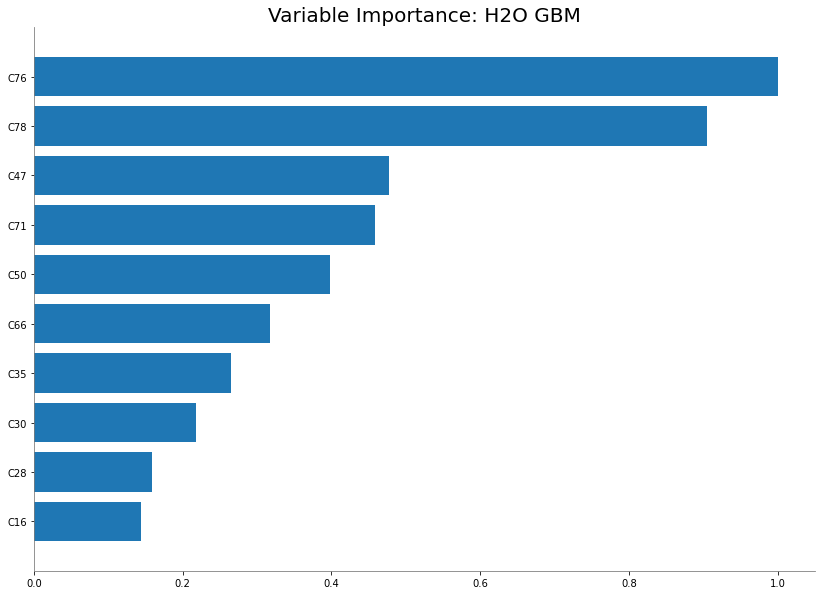

In [41]:
gbm_balanced.varimp_plot()

C50 is important feature for target label.

Headlines column will have text data We will add another feature 'headlines' to our existing trainingset and interpret the performance. 

In [42]:
headline_vecs = vec_model.transform(words_headline, aggregate_method = "AVERAGE")
headline_vecs.names = ["headline_" + s for s in headline_vecs.names]

In [43]:
headline_vecs.head()

headline_C1,headline_C2,headline_C3,headline_C4,headline_C5,headline_C6,headline_C7,headline_C8,headline_C9,headline_C10,headline_C11,headline_C12,headline_C13,headline_C14,headline_C15,headline_C16,headline_C17,headline_C18,headline_C19,headline_C20,headline_C21,headline_C22,headline_C23,headline_C24,headline_C25,headline_C26,headline_C27,headline_C28,headline_C29,headline_C30,headline_C31,headline_C32,headline_C33,headline_C34,headline_C35,headline_C36,headline_C37,headline_C38,headline_C39,headline_C40,headline_C41,headline_C42,headline_C43,headline_C44,headline_C45,headline_C46,headline_C47,headline_C48,headline_C49,headline_C50,headline_C51,headline_C52,headline_C53,headline_C54,headline_C55,headline_C56,headline_C57,headline_C58,headline_C59,headline_C60,headline_C61,headline_C62,headline_C63,headline_C64,headline_C65,headline_C66,headline_C67,headline_C68,headline_C69,headline_C70,headline_C71,headline_C72,headline_C73,headline_C74,headline_C75,headline_C76,headline_C77,headline_C78,headline_C79,headline_C80,headline_C81,headline_C82,headline_C83,headline_C84,headline_C85,headline_C86,headline_C87,headline_C88,headline_C89,headline_C90,headline_C91,headline_C92,headline_C93,headline_C94,headline_C95,headline_C96,headline_C97,headline_C98,headline_C99,headline_C100
-0.105602,-0.328054,-0.112324,-0.0253121,0.1729,-0.0869874,0.00680927,-0.0845275,0.0516046,-0.158925,0.16158,-0.065333,-0.00534703,0.0198024,0.171115,-0.0678068,-0.0242358,-0.0792547,-0.0492161,0.0592144,0.0217273,-0.115894,-0.163839,-0.177782,0.260756,-0.00180721,-0.0638511,-0.249128,-0.0703273,0.206365,0.0425415,0.00254193,1.46627e-05,0.0684066,-0.125784,0.123859,0.0526515,-0.0561838,0.067258,-0.113028,-0.0501009,0.211503,-0.0673861,0.0267889,-0.0360204,-0.0946724,0.0891744,0.217747,-0.0882616,-0.217938,0.0801429,0.248751,-0.197214,0.0340949,-0.184538,0.0006603,-0.0970123,0.146329,0.147554,0.18224,0.122027,-0.125292,0.127735,0.0888674,-0.180743,0.0884998,0.0762026,-0.0196716,-0.325197,-0.112397,-0.208096,0.0683762,-0.192196,0.0998402,0.100275,-0.0376627,0.134213,0.0596961,-0.0161603,0.000954804,-0.218178,0.0225384,0.362016,-0.0956107,-0.0467081,-0.126719,-0.0150141,0.178586,0.0258339,0.0344777,-0.118883,-0.0103178,0.0455266,0.12315,-0.174194,-0.0319825,-0.0432474,-0.232297,-0.21424,0.0613975
-0.323755,-0.0214788,-0.0265393,-0.023732,0.074015,-0.0878253,-0.114146,0.00972323,0.0940257,-0.222923,-0.02835,-0.106361,0.0050534,-0.144219,-0.125922,-0.0961963,-0.185872,-0.113117,0.0677055,-0.0820835,0.0835124,-0.189333,0.00445894,0.0237188,-0.0801471,-0.324096,0.0191151,0.0489571,-0.180211,0.0544831,-0.0539992,-0.0413986,-0.0666822,0.058961,0.117693,0.0589091,0.14423,0.0220138,0.174635,-0.0532536,-0.116862,0.0227773,0.0483375,0.0357225,0.0584756,0.0868885,0.0155859,-0.12958,-0.164614,0.079812,-0.0610178,0.0664872,-0.0601594,-0.0215888,-0.0613494,0.0531643,-0.111894,0.0696821,0.197013,0.116674,0.126421,-0.0170416,0.0950132,0.09398,-0.147911,0.0811506,0.20932,-0.342059,-0.231516,-0.0996702,-0.101782,0.0506227,-0.164408,0.1454,-0.0491618,-0.112007,-0.0104642,0.0113865,-0.162786,0.214296,-0.174304,0.213907,0.154198,-0.0134722,-0.175201,-0.112382,0.165767,0.183569,-0.0424013,-0.0428745,0.0182356,-0.0183405,0.0499591,-0.0274805,-0.0305212,0.0320411,0.16195,-0.0819155,0.029313,-0.0213744
-0.167555,-0.0556319,-0.197222,-0.0425217,0.118573,-0.131173,0.0968758,-0.10138,0.0923252,-0.133861,0.177402,-0.0227283,-0.0381382,-0.0059253,-0.0605872,0.218547,-0.182531,0.00843527,0.213057,-0.0575837,0.0209008,-0.0270239,-0.27514,-0.181281,0.177839,0.0275707,0.0437503,-0.0864234,-0.0944459,-0.0480956,-0.15682,-0.196731,-0.0256261,0.0835841,-0.154437,0.182552,0.149058,-0.312695,-0.0609326,0.0752443,-0.233623,-0.0560755,0.0271478,0.156188,-0.16788,-0.205136,0.243779,-0.17163,-0.021051,-0.0882941,0.204042,0.0195495,-0.106757,-0.0988268,-0.0334742,-0.184784,-0.222292,-0.00555257,0.372638,0.217034,0.0751041,-0.198622,0.128798,0.15907,-0.000770155,-0.0385072,-0.0693511,-0.00316574,-0.167431,-

In [44]:
h2o_df_ext = h2o_df_ext.cbind(headline_vecs)

In [45]:
h2o_train,h2o_valid = h2o_df_ext.split_frame(ratios=[.8])
gbm_two_cols = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10
                                             )

In [46]:
gbm_two_cols.train(x=headline_vecs.names+review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [47]:
print(" Two Columns AUC: " + str(round(gbm_two_cols.auc(valid = True), 3)))

 Two Columns AUC: 0.923


In [48]:
gbm_two_cols.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5588490705509269: 


,,0,1,Error,Rate
0,0,3161.0,1475.0,0.3182,(1475.0/4636.0)
1,1,741.0,11917.0,0.0585,(741.0/12658.0)
2,Total,3902.0,13392.0,0.1281,(2216.0/17294.0)


In [49]:
gbm_two_cols.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-02 04:39:40,0.005 sec,0.0,0.445793,0.586782,0.500000,0.726426,1.000000,0.273574,0.442988,0.581406,0.500000,0.731930,1.000000,0.268070
1,,2020-09-02 04:39:49,8.118 sec,10.0,0.364451,0.428140,0.892748,0.953554,1.374677,0.158123,0.364683,0.428920,0.884574,0.950210,1.362267,0.160923
2,,2020-09-02 04:39:57,16.053 sec,20.0,0.333584,0.367523,0.913266,0.963126,1.376603,0.140580,0.336433,0.372728,0.903012,0.958588,1.366251,0.146004
3,,2020-09-02 04:40:04,23.775 sec,30.0,0.316704,0.333715,0.925342,0.968541,1.376603,0.130112,0.322168,0.343114,0.913368,0.963270,1.366251,0.136464
4,,2020-09-02 04:40:12,31.535 sec,40.0,0.305837,0.312052,0.932732,0.971918,1.376603,0.124492,0.313882,0.325513,0.918990,0.965845,1.366251,0.130970
5,,2020-09-02 04:40:20,39.200 sec,50.0,0.297734,0.296131,0.938388,0.974420,1.376603,0.117941,0.308357,0.313524,0.922875,0.967587,1.366251,0.128137


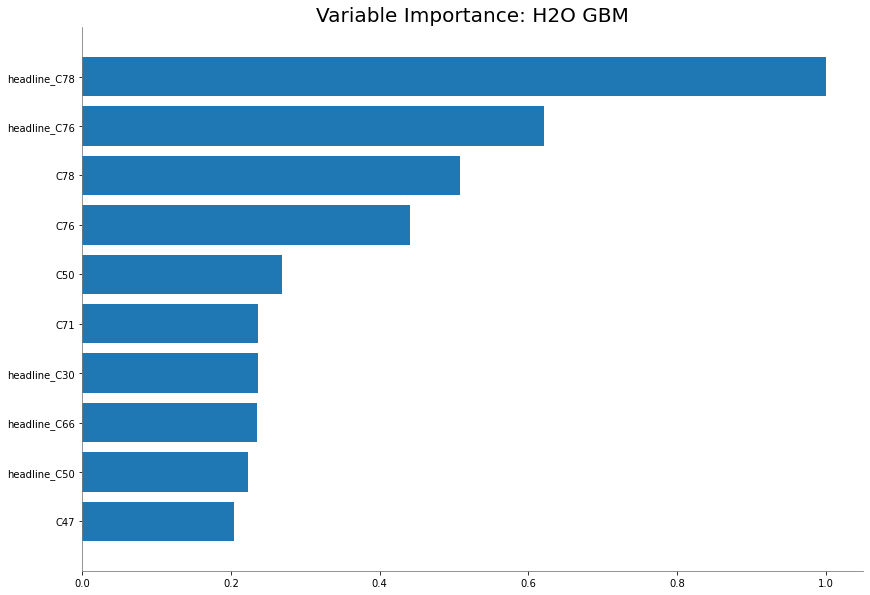

In [50]:
gbm_two_cols.varimp_plot()

In [51]:
ntrees_opt = [100, 200, 250, 300]
max_depth_opt = [6, 7, 8]
learn_rate_opt = [0.01, 0.1]

hyper_parameters = {"ntrees": ntrees_opt,"max_depth":max_depth_opt, "learn_rate":learn_rate_opt}
search_criteria = {"strategy":"RandomDiscrete","max_models":4}

In [52]:
from h2o.grid.grid_search import H2OGridSearch
gs = H2OGridSearch(H2OGradientBoostingEstimator,hyper_params=hyper_parameters, search_criteria=search_criteria)

In [53]:
gs.train(x=review_vecs.names+headline_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [54]:
print(gs.get_grid(sort_by='auc', decreasing=True))

     ...                 auc
0    ...  0.9403627364947443
1    ...  0.9232173915325471
2    ...  0.9166242235673443
3    ...  0.9031523510046131

[4 rows x 6 columns]



Maximum AUC score using our hyperparameter range resulted in 94%.

In [55]:
# Grab the top GBM model, chosen by validation AUC
best_gbm = gs.models[0]
print(best_gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_389_sid_8375_model_python_1599014842879_542_model_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,250.0,250.0,197135.0,6.0,6.0,6.0,34.0,64.0,58.08




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03924997213464293
RMSE: 0.19811605723576
LogLoss: 0.1486595366849771
Mean Per-Class Error: 0.05148592313990641
AUC: 0.9887544214471556
AUCPR: 0.9955135519162721
Gini: 0.9775088428943113

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5398777251173558: 


,,0,1,Error,Rate
0,0,16868.0,1923.0,0.1023,(1923.0/18791.0)
1,1,1062.0,48834.0,0.0213,(1062.0/49896.0)
2,Total,17930.0,50757.0,0.0435,(2985.0/68687.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.539878,0.970344,215.0
1,max f2,0.400773,0.979450,253.0
2,max f0point5,0.692847,0.973509,170.0
3,max accuracy,0.549134,0.956571,213.0
4,max precision,0.998752,1.000000,0.0
5,max recall,0.021365,1.000000,386.0
6,max specificity,0.998752,1.000000,0.0
7,max absolute_mcc,0.579246,0.890038,204.0
8,max min_per_class_accuracy,0.681944,0.947794,173.0
9,max mean_per_class_accuracy,0.655130,0.948514,182.0



Gains/Lift Table: Avg response rate: 72.64 %, avg score: 72.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011836,0.998744,1.376603,1.376603,1.000000,0.998943,1.000000,0.998943,0.016294,0.016294,37.660333,37.660333,0.016294
1,2,0.020047,0.998476,1.376603,1.376603,1.000000,0.998598,1.000000,0.998802,0.011304,0.027597,37.660333,37.660333,0.027597
2,3,0.030006,0.998149,1.376603,1.376603,1.000000,0.998310,1.000000,0.998639,0.013709,0.041306,37.660333,37.660333,0.041306
3,4,0.040008,0.997821,1.376603,1.376603,1.000000,0.997982,1.000000,0.998474,0.013769,0.055075,37.660333,37.660333,0.055075
4,5,0.050009,0.997543,1.376603,1.376603,1.000000,0.997683,1.000000,0.998316,0.013769,0.068843,37.660333,37.660333,0.068843
5,6,0.100063,0.995690,1.376603,1.376603,1.000000,0.996648,1.000000,0.997482,0.068903,0.137747,37.660333,37.660333,0.137747
6,7,0.149999,0.993043,1.376202,1.376470,0.999708,0.994439,0.999903,0.996469,0.068723,0.206469,37.620199,37.646972,0.206416
7,8,0.200009,0.989605,1.375802,1.376303,0.999418,0.991345,0.999782,0.995188,0.068803,0.275273,37.580182,37.630272,0.275113
8,9,0.299999,0.979614,1.375802,1.376136,0.999418,0.984985,0.999660,0.991787,0.137566,0.412839,37.580159,37.613569,0.412466
9,10,0.400003,0.962627,1.373798,1.375551,0.997962,0.971946,0.999236,0.986826,0.137386,0.550224,37.379762,37.555115,0.549107




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0817591485083799
RMSE: 0.28593556705730033
LogLoss: 0.2661731702155768
Mean Per-Class Error: 0.13321098451040458
AUC: 0.9403627364947443
AUCPR: 0.975201997936584
Gini: 0.8807254729894887

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.487069104449131: 


,,0,1,Error,Rate
0,0,3306.0,1330.0,0.2869,(1330.0/4636.0)
1,1,650.0,12008.0,0.0514,(650.0/12658.0)
2,Total,3956.0,13338.0,0.1145,(1980.0/17294.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.487069,0.923834,236.0
1,max f2,0.168705,0.955943,329.0
2,max f0point5,0.799590,0.929896,128.0
3,max accuracy,0.528728,0.886377,223.0
4,max precision,0.998766,1.000000,0.0
5,max recall,0.015094,1.000000,389.0
6,max specificity,0.998766,1.000000,0.0
7,max absolute_mcc,0.596425,0.705928,202.0
8,max min_per_class_accuracy,0.754908,0.866695,144.0
9,max mean_per_class_accuracy,0.754908,0.866789,144.0



Gains/Lift Table: Avg response rate: 73.19 %, avg score: 73.53 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011160,0.998744,1.366251,1.366251,1.000000,0.998925,1.000000,0.998925,0.015247,0.015247,36.625059,36.625059,0.015247
1,2,0.020007,0.998453,1.366251,1.366251,1.000000,0.998592,1.000000,0.998778,0.012087,0.027334,36.625059,36.625059,0.027334
2,3,0.030010,0.998141,1.366251,1.366251,1.000000,0.998300,1.000000,0.998619,0.013667,0.041002,36.625059,36.625059,0.041002
3,4,0.040014,0.997820,1.358353,1.364276,0.994220,0.997980,0.998555,0.998459,0.013588,0.054590,35.835319,36.427624,0.054374
4,5,0.050017,0.997522,1.366251,1.364671,1.000000,0.997667,0.998844,0.998300,0.013667,0.068257,36.625059,36.467111,0.068042
5,6,0.100035,0.995491,1.363092,1.363881,0.997688,0.996571,0.998266,0.997436,0.068178,0.136435,36.309163,36.388137,0.135788
6,7,0.149994,0.992726,1.353600,1.360457,0.990741,0.994132,0.995759,0.996335,0.067625,0.204061,35.360012,36.045693,0.201688
7,8,0.200012,0.989337,1.356774,1.359536,0.993064,0.991098,0.995085,0.995025,0.067862,0.271923,35.677371,35.953586,0.268256
8,9,0.299988,0.978511,1.345705,1.354927,0.984962,0.984456,0.991712,0.991503,0.134539,0.406462,34.570547,35.492662,0.397187
9,10,0.400023,0.960351,1.327553,1.348081,0.971676,0.970042,0.986701,0.986136,0.132801,0.539264,32.755332,34.808132,0.519419




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-02 04:45:54,5 min 32.691 sec,0.0,0.445793,0.586782,0.500000,0.726426,1.000000,0.273574,0.442988,0.581406,0.500000,0.731930,1.000000,0.268070
1,,2020-09-02 04:45:55,5 min 33.738 sec,1.0,0.430600,0.554403,0.842496,0.926026,1.349644,0.184183,0.428475,0.550636,0.830316,0.921359,1.337678,0.187406
2,,2020-09-02 04:45:55,5 min 34.636 sec,2.0,0.417765,0.528888,0.860291,0.936626,1.363349,0.175550,0.416335,0.526571,0.848365,0.932244,1.351086,0.181277
3,,2020-09-02 04:45:56,5 min 35.532 sec,3.0,0.406409,0.507107,0.874068,0.944633,1.372202,0.173235,0.405358,0.505521,0.863858,0.940466,1.359381,0.176709
4,,2020-09-02 04:45:57,5 min 36.487 sec,4.0,0.396808,0.489106,0.878180,0.946481,1.372202,0.167266,0.396257,0.488421,0.868364,0.942785,1.359381,0.173066
5,,2020-09-02 04:46:02,5 min 40.728 sec,9.0,0.360855,0.421983,0.902626,0.958014,1.375274,0.149315,0.362762,0.425478,0.890671,0.952979,1.362865,0.154794
6,,2020-09-02 04:46:06,5 min 45.003 sec,14.0,0.339470,0.381234,0.915356,0.963927,1.376603,0.139095,0.343647,0.388588,0.900698,0.957362,1.359022,0.144906
7,,2020-09-02 04:46:10,5 min 49.240 sec,19.0,0.324854,0.352855,0.924198,0.968002,1.376603,0.131408,0.331646,0.364233,0.907948,0.960799,1.366251,0.138950
8,,2020-09-02 04:46:14,5 min 53.605 sec,24.0,0.314005,0.331335,0.930674,0.970923,1.376603,0.124871,0.323361,0.346645,0.912880,0.963056,1.366251,0.136926
9,,2020-09-02 04:46:19,5 min 57.960 sec,29.0,0.305857,0.315455,0.935881,0.973235,1.376603,0.119106,0.317777,0.334668,0.916405,0.964540,1.366251,0.133572



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,headline_C78,5570.801270,1.000000,0.108105
1,headline_C76,3699.310547,0.664054,0.071787
2,C78,2898.809326,0.520358,0.056253
3,C76,2428.521240,0.435938,0.047127
4,headline_C50,1736.409424,0.311698,0.033696
5,C50,1598.549316,0.286951,0.031021
6,C71,1433.270386,0.257283,0.027813
7,headline_C66,1315.909546,0.236215,0.025536
8,C47,1198.292603,0.215102,0.023254
9,headline_C71,1192.732666,0.214104,0.023146



See the whole table with table.as_data_frame()



Saving Trained model:

In [56]:
h2o.save_model(gbm_two_cols)

'/content/GBM_model_python_1599014842879_529'

Model Interpretation

Headline_C78 vector contributes more in Star Rating

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/h2o/model/model_base.py:1365: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)



PartialDependence: Partial Dependence Plot of model GBM_model_python_1599014842879_529 on column 'headline_C78'.


,headline_c78,mean_response,stddev_response,std_error_mean_response
0,-0.993536,0.662809,0.274316,0.000936
1,-0.878862,0.662809,0.274316,0.000936
2,-0.764188,0.662809,0.274316,0.000936
3,-0.649514,0.662809,0.274316,0.000936
4,-0.534840,0.662809,0.274316,0.000936
5,-0.420166,0.662809,0.274316,0.000936
6,-0.305492,0.662809,0.274316,0.000936
7,-0.190818,0.662809,0.274316,0.000936
8,-0.076144,0.668049,0.275624,0.000940
9,0.038529,0.742599,0.258417,0.000881


[]

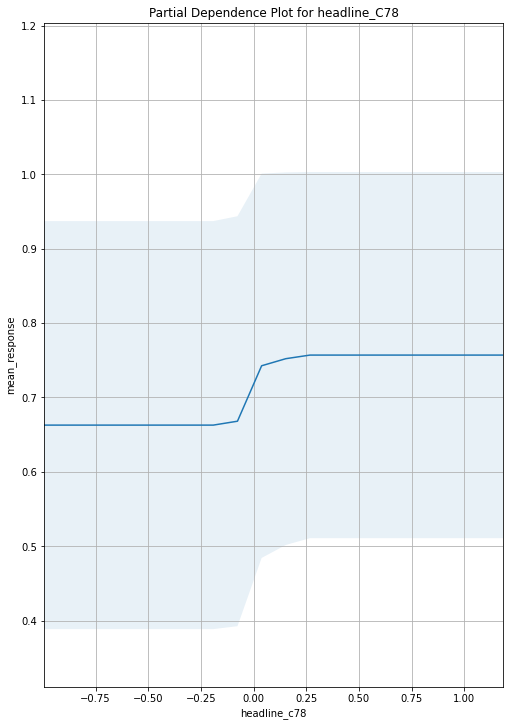

In [57]:
gbm_two_cols.partial_plot(data=h2o_df_ext, cols =['headline_C78'])

Partial Plot tells probaility of each words contributes to target classes. As you see vectors representation starting from -0.75 till 0.25 contributes to low rating and it shifts to high rating when word vec represenation more than 0.05

We will find what are the words in Headline_C78.

In [58]:
unique_words= words_headline.asfactor().unique().ascharacter()

In [59]:
unique_words.col_names= ['word']
word_embeddings = vec_model.transform(unique_words, aggregate_method="NONE")
word_embeddings = unique_words.cbind(word_embeddings)
word_embeddings = word_embeddings[~(word_embeddings['C1'].isna())]

In [60]:
word_embeddings

word,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
00,0.228108,0.280236,-0.187545,-0.473983,-0.593945,-0.657005,0.102566,0.169631,-0.257797,0.116306,0.13064,-0.326737,-0.0515613,0.332201,-0.286425,-0.284229,0.147689,-0.0229232,-0.110106,-0.192198,0.038177,-0.0757505,-0.507836,-0.122989,0.269008,-0.234565,-0.0793573,-0.207649,0.0728796,-0.0919833,0.159451,0.182034,-0.237844,0.10786,-0.16736,0.119918,0.164523,-0.444617,-0.399994,0.0783868,0.271767,-0.011722,-0.258863,-0.195919,0.063584,0.316834,-0.135511,0.001328,0.117926,0.612688,0.307583,0.21117,-0.106617,0.322562,0.0185709,-0.192732,-0.371523,-0.269065,0.397731,0.533817,-0.115797,-0.380443,-0.423546,0.339727,-0.0738275,0.303186,0.375744,-0.150689,-0.135577,-0.616332,-0.231145,0.234142,0.00965952,0.245908,0.129079,-0.255771,-0.302407,0.221862,-0.334731,0.0242169,-0.24048,-0.164635,-0.359329,-0.177743,-0.0391219,-0.283926,0.0609729,-0.175668,-0.118541,0.159854,-0.55822,-0.239945,0.120845,0.0834161,-0.565533,-0.355692,-0.101306,-0.335033,-0.101173,0.199193
000,0.444951,0.306018,0.479745,-0.727633,-0.334895,-0.955278,0.206703,0.425563,0.625683,-0.165027,0.404669,0.0459202,0.116714,0.448959,-0.11611,-0.615901,0.275895,-0.136055,-0.0789144,0.0309904,0.0494764,0.0095834,-0.389096,0.194455,-0.156858,-0.138754,0.228649,0.231437,0.224076,-0.384917,-0.0679765,-0.0365912,-0.0332806,-0.0352074,-0.369581,0.355189,-0.145959,-0.0604531,-0.269245,0.526398,0.548953,0.373084,-0.452929,-0.367661,-0.132109,0.470162,0.0351797,0.313618,-0.239419,-0.00507376,0.0132168,-0.0337314,0.218951,0.166355,0.378417,-0.0117439,-0.158465,-0.235514,0.183785,-0.241501,0.448582,-0.630025,-0.00450026,0.075912,0.445202,0.00216235,0.269447,-0.251406,0.220386,-0.399479,-0.640778,-0.32016,0.197862,-0.495609,-0.135508,-0.120383,0.110772,0.537926,-0.623687,0.18628,-0.468816,0.379953,-0.197165,0.0160017,-0.333685,-0.450341,0.0257832,0.159899,0.0148275,-0.00662263,-1.0198,0.118669,0.426325,0.186952,-0.0956334,0.0902557,-0.369636,0.162015,-0.162656,-0.0177045
0000,-0.115138,-0.0902881,0.330887,0.0125297,-0.102106,-0.164122,-0.0307625,0.140332,0.308897,-0.245852,0.0200833,-0.169629,-0.135666,-0.445892,-0.0289442,-0.181879,0.232176,0.171703,0.103521,0.146014,0.0760192,-0.087012,0.0451134,0.0229753,-0.105686,-0.217651,-0.160657,-0.110604,-0.134259,0.0754665,0.0546637,0.073512,0.147277,0.012574,-0.146582,-0.111499,0.231272,0.116778,0.282267,-0.0471306,0.0498835,-0.0209659,-0.113995,-0.0373253,0.04341,0.0155511,-0.0836324,-0.0128487,-0.104623,0.0603952,-0.105218,-0.185698,-0.0445347,-0.0615145,0.000103771,0.0179205,-0.0542813,0.0405108,0.0301752,-0.00952967,0.211112,-0.0602791,0.0782948,0.197161,-0.110785,0.0867301,-0.00608915,-0.161531,0.105438,-0.0908302,-0.140836,0.186149,-0.0790493,0.203731,0.0836422,-0.0440243,0.168811,-0.0822381,-0.131844,0.0199233,0.0341202,0.0433514,0.0453021,0.0821945,-0.098026,-0.0689528,-0.0561958,0.191757,-0.00572217,0.130927,-0.194222,-0.0942235,0.121696,-0.019105,0.134095,0.0372598,0.211938,-0.00811557,-0.00111202,0.143214
007,-0.240234,-0.102658,0.176662,0.0469465,-0.200186,-0.0827779,0.227972,0.237899,0.324358,-0.0301489,0.0245937,0.0297424,-0.339289,-0.191153,0.108929,0.011065,0.0537095,0.082185,0.194906,0.102493,0.0344396,-0.12142,0.289237,0.134372,-0.183324,-0.29375,-0.059795,-0.449529,0.0112553,0.0545205,-0.0989176,0.250433,0.0240258,0.150031,0.0592772,-0.0509844,0.225687,0.211115,0.0230838,-0.162944,-0.0345161,0.175732,0.0146216,-0.117697,0.13044,-0.0222307,0.0862981,-0.0382992,-0.0612486,0.000959669,-0.184163,-0.0955336,-0.192362,-0.173378,0.193603,0.125975,-0.00203947,-0.0521423,0.302949,-0.0702397,0.136133,-0.122275,0.168848,0.232309,-0.0288806,-0.0

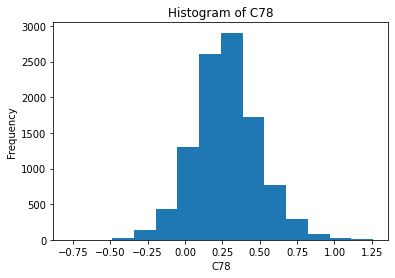

In [61]:
word_embeddings['C78'].hist()

History shows distribution of word vectors in Headline_C78.

In [62]:
low_c78_words= word_embeddings[word_embeddings['C78'] < -0.25]
low_c78_words[['word', 'C78']].head(20)

word,C78
05,-0.290045
1000l,-0.298752
2008,-0.305591
2009,-0.487267
2010,-0.428902
2012,-0.593047
2013,-0.588508
2014,-0.412608
2015,-0.278185
3m,-0.320499


In [63]:
low_c78_words= word_embeddings[word_embeddings['C78'] > 0.05]
low_c78_words[['word', 'C78']].head(20)

word,C78
00,0.221862
000,0.537926
007,0.182249
01500,0.119856
02,0.104046
04,0.090317
10,0.233827
100,0.2778
100mm,0.243878
100s,0.0978326
